## **Multi Modal Self-Supervised Fusion**
**- Fine tuning the MMFusion model (ConvRNN_Model.pth)**

In [1]:
import numpy as np
import os 
from pathlib import Path
from tqdm import tqdm
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
import torchmetrics
import random
import torch
import tensorflow as tf
import torchvision.transforms as transforms
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

from sources import utils_spec, models,MMFusion_Model
import matplotlib.pyplot as plt

### **A) Define the touchgesture model:**

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
touchModel = MMFusion_Model.TouchGestureModel(input_size=4, hidden_size=256, seq_length=1250, num_layers=2, batch_size=16, num_classes=100).to(device)

### **B) Define the spectrogram model:**

In [3]:
specModel = MMFusion_Model.SpectrogramModel(num_classes=100).to(device)

In [4]:
def testSpec(model, input):
    x = input.to(device)
    y0 = model(x)
    print("Output shape of spectrogram model: \n", y0.shape)
    print(y0)
    return y0

def testTouch(model, in_planes):
    x = torch.randn(16, in_planes, 1250)
    x = x.to(device)
    y0 = model(x)
    print("output shape of touch model: \n", y0.shape)
    print(y0)
    return y0

In [5]:
x_spec = torch.randn(16, 3, 65, 71)
y_spec = testSpec(specModel, input = x_spec)
y_touch = testTouch(touchModel, in_planes=4)

Output shape of spectrogram model: 
 torch.Size([16, 256])
tensor([[ 0.6819, -0.0512,  0.1953,  ..., -0.3903, -0.0924, -0.4498],
        [ 0.4018, -0.0361, -0.4273,  ..., -0.2998, -0.3999,  0.2442],
        [-0.6432, -0.6155, -0.3044,  ...,  0.1008, -0.2851,  0.4276],
        ...,
        [-0.2132,  0.5525,  0.1639,  ..., -0.3541, -0.6319, -0.5407],
        [ 0.0925, -0.2507,  0.3709,  ...,  0.3511, -0.5716,  0.1970],
        [-0.0789,  0.0521,  0.1165,  ...,  0.0047, -0.0808, -0.0916]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
output shape of touch model: 
 torch.Size([16, 256])
tensor([[ 0.0402,  0.0675, -0.5002,  ...,  0.5387, -0.3509,  0.2728],
        [-0.5153,  0.3145, -0.4745,  ..., -0.5409,  0.2191, -0.3210],
        [ 0.1369, -0.0533,  0.2283,  ...,  0.4108,  0.2114,  0.1323],
        ...,
        [-0.1731,  0.3133,  0.0318,  ...,  0.3319,  0.2089,  0.1759],
        [-0.5046,  0.5396,  0.3244,  ..., -0.1654, -0.6807,  0.7575],
        [ 0.1612,  0.1104,  0.1258,  ...,

In [6]:
Logs, touch_ds, y = utils_spec.dataGenerator(numUsers=1, evaluation=True, pretraining=False)

userID 0


100%|██████████| 12/12 [00:08<00:00,  1.45it/s]


userID 1


100%|██████████| 12/12 [00:07<00:00,  1.69it/s]

(24, 10000, 3)
(24, 10000, 4)
(24,)


### Shape of Logs: (2, 10000, 3), because I have computed the norm for each sensor before loading them

In [7]:
numof_chunks = 8 # divide data on multu chunks (numof_chunks = 1 -> process the hole csv file)

Logs_2 = Logs.reshape(Logs.shape[0] * numof_chunks, Logs.shape[1]//numof_chunks, -1)

y_labels = []

for y0 in y:
    y_labels.append(np.zeros(numof_chunks) + y0)

y_labels = np.reshape(y_labels, -1)

print(Logs_2.shape)
print(y_labels.shape)

(192, 1250, 3)
(192,)


In [8]:
touch_logs = touch_ds.reshape(touch_ds.shape[0]*numof_chunks, touch_ds.shape[1]//numof_chunks, -1)
print(touch_logs.shape)

(192, 1250, 4)


In [9]:
x_spec = []
y_spec = []

#transpose data, fourier transform is applied on horizontal data
X = np.transpose(Logs_2, axes = [0, -1, 1])
print(X.shape)

for i, x in enumerate(tqdm(X)):
    x = abs(tf.signal.stft(x, 128, 16))
    x_spec.append(x)#, window_fn=window_fn))
    
x_spec = np.stack(x_spec)

#put the number of channels in the last axe to have the same data format supported by TensorFlow (9 channels) 
x_spec = np.transpose(x_spec, axes = [0, 3, 2, 1])
# config originale: [0, 3, 2, 1]

print(x_spec.shape)


(192, 3, 1250)


100%|██████████| 192/192 [00:01<00:00, 154.98it/s]

(192, 65, 71, 3)


In [10]:
sensorFusion = MMFusion_Model.fusionFFN(num_logits=256).to(device)
touchFusion = MMFusion_Model.fusionFFN(num_logits=256).to(device)

finetuned_fusion_model = MMFusion_Model.pred_model(sensorModelPred=specModel, touchModelPred=touchModel, sensorFusionPred=sensorFusion, touchFusionPred=touchFusion, fusion=True).to(device)

In [11]:
def test_fusion_pred():
    x1 = torch.randn(16, 3, 65, 71).to(device)
    x2 = torch.randn(16,4, 1250).to(device)
    y_i, y_j, y_fi, y_fj = finetuned_fusion_model(x1, x2)
    return y_i, y_j, y_fi, y_fj

y0, y1, y2, y3 =test_fusion_pred()

In [12]:
print(y0.shape)
print(y1.shape)
print(y2.shape)
print(y3.shape)

torch.Size([16, 256])
torch.Size([16, 256])
torch.Size([16, 256])
torch.Size([16, 256])


In [13]:
x_train_sensor, x_test_sensor, y_train_sensor, y_test_sensor = train_test_split(x_spec, y_labels, test_size=0.8, shuffle=False, random_state=10)
x_train_touch, x_test_touch, y_train_touch, y_test_touch = train_test_split(touch_logs, y_labels, test_size=0.8, shuffle=False, random_state=10)

### **Dataset:**

In [14]:
class customDataset(Dataset):
    def __init__(self, sensorData, touchData, Y, transform=None):
        self.sensorData = np.array(sensorData)
        self.touchData = np.array(touchData)

        self.labels = np.array(Y)
        self.transform = transform

    def __getitem__(self, i):
        
        X_i = self.sensorData[i]
        X_j = self.touchData[i]

        X_i = self.transform(X_i)
        X_j = self.transform(X_j)

        y = self.labels[i]

        return (X_i, X_j, y)
    
    def __len__(self):
        return len(self.touchData)

In [15]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
transform = transforms.Compose([transforms.ToTensor()])
train_set = customDataset(sensorData=x_train_sensor, touchData=x_train_touch, Y=y_train_sensor, transform=transform)
test_set = customDataset(sensorData=x_test_sensor, touchData=x_test_touch, Y=y_test_sensor,transform=transform)

In [16]:
train_loader = DataLoader(train_set, batch_size=16, shuffle=False, drop_last=True)
test_loader = DataLoader(test_set, batch_size=16, drop_last=True)

##### **Display the data from train and test loaders**

In [17]:
for i ,(x1,x2, y)  in enumerate(train_loader):
    x1 = np.squeeze(x1, axis=1)
    x2 = np.squeeze(x2, axis=1)
    print("Train Sample: ", i)
    print("X1 shape:{}".format(x1.shape))
    print("X2 Shape:{}".format(x2.shape))
    print("Shape of labels:{}".format(y.shape))
    break

Train Sample:  0
X1 shape:torch.Size([16, 3, 65, 71])
X2 Shape:torch.Size([16, 1250, 4])
Shape of labels:torch.Size([16])


In [18]:
for i ,(x1,x2, y)  in enumerate(test_loader):
    x1 = np.squeeze(x1, axis=1)
    x2 = np.squeeze(x2, axis=1)
    print("Train Sample: ", i)
    print("X1 shape:{}".format(x1.shape))
    print("X2 Shape:{}".format(x2.shape))
    print("Shape of labels:{}".format(y.shape))
    break

Train Sample:  0
X1 shape:torch.Size([16, 3, 65, 71])
X2 Shape:torch.Size([16, 1250, 4])
Shape of labels:torch.Size([16])


### **D) Load the finetuned ConvRNN model:**

In [19]:
finetuned_path = 'finetuned_models/fusion/'
finetuned_file_name = 'ConvRNN_finetuned_TF_accelerometer.pth'
path_folder = os.path.join(finetuned_path, finetuned_file_name)
ft_model = models.downstream_model.DSModel_Fusion(finetuned_fusion_model, num_classes=1, fusion=True).to(device)
x = ft_model.load_state_dict(torch.load(path_folder, map_location=device), strict=False)

In [20]:
x

<All keys matched successfully>

### **E) Run the model (ConvRNN) on train and test data as a feature extractor:**

In [21]:
train_target = []
train_embedding = []

test_target = []
test_embedding = []
probas_train = []
probas_test = []
predicted_target = []

ft_model.eval()

for i, (x1, x2, y) in enumerate(train_loader):
    train_labels = y.clone().detach()
    x_i, x_j = x1.to(device, dtype=torch.int64), x2.to(device, dtype=torch.int64)
    train_labels = train_labels.to(device, dtype=torch.int64)

    x_i = x_i.float()
    x_j = x_j.float()
    #train_labels.squeeze(1)

    train_scores, embedding = ft_model(x_i, x_j)

    train_embedding.extend(embedding.detach().cpu())
    train_target.extend(train_labels.cpu().tolist())
    probas_train.extend(train_scores.detach().cpu().tolist())
    #train_target.extend(train_labels.squeeze(-1).numpy())

for i, (x1, x2, y) in enumerate(test_loader):

    test_labels = y.clone().detach()
    x_i, x_j = x1.to(device, dtype=torch.int64), x2.to(device, dtype=torch.int64)
    test_labels = test_labels.to(device, dtype=torch.int64)

    x_i = x_i.float()
    x_j = x_j.float()
    #test_labels.squeeze(1)

    test_scores, embedding = ft_model(x_i, x_j)
    p_target = (test_scores > 0.5).long()
    
    predicted_target.extend(p_target.detach().cpu().tolist())

    test_embedding.extend(embedding.detach().cpu())
    
    test_target.extend(test_labels.detach().cpu().tolist())
   
    probas_test.extend(test_scores.detach().cpu().tolist())

In [22]:
train_embedding = np.vstack(train_embedding)
train_target = np.array(train_target)

test_embedding = np.vstack(test_embedding)
test_target = np.array(test_target)

probas_train = np.array(probas_train)
probas_test = np.array(probas_test)

In [23]:
predicted_target = np.array(predicted_target).squeeze()

In [24]:
type(probas_test)

numpy.ndarray

In [25]:
probas_train = (probas_train - probas_train.mean())/probas_train.std()

In [26]:
probas_train

array([[-0.23482505],
       [-0.25834121],
       [-0.26318673],
       [-0.22427642],
       [-0.24488665],
       [-0.24664445],
       [-0.23491203],
       [-0.19376091],
       [-0.26383696],
       [-0.25396875],
       [-0.24820923],
       [-0.25728911],
       [-0.24958109],
       [-0.25162185],
       [-0.25009214],
       [-0.25992756],
       [-0.25215257],
       [ 0.11634477],
       [-0.08856983],
       [-0.10719819],
       [-0.13360446],
       [-0.15804396],
       [-0.14294834],
       [-0.0583008 ],
       [-0.20830584],
       [-0.249429  ],
       [ 5.50731941],
       [-0.23297143],
       [ 0.51287569],
       [-0.18376179],
       [-0.15715822],
       [-0.2287353 ]])

In [27]:
probas_test = (probas_test - probas_test.mean())/probas_test.std()

In [28]:
probas_test.ravel().shape

(144,)

### **F) Plot the ROC obtained with the linear classifier:**

In [29]:
ROC = torchmetrics.ROC(task='binary')

In [30]:
fpr_nn, tpr_nn, th_nn = ROC(torch.tensor(probas_test.ravel()), torch.tensor(test_target))

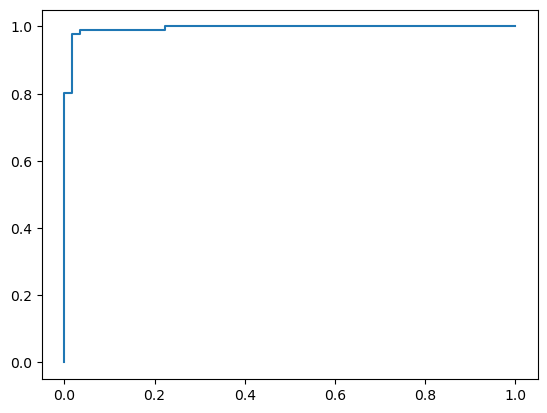

In [31]:
plt.plot(fpr_nn, tpr_nn)

In [32]:
auc_model = auc(fpr_nn, tpr_nn)
auc_model*100

99.39855933189392

In [47]:
auc_list = [99.71, 99.53, 99.57, 99.77, 99.59, 99.67, 99.55, 99.63, 99.61, 99.39]

auc_array = np.array(auc_list)
avg_auc = np.mean(auc_array)
std_auc = np.std(auc_array)
print("Average AUC: ", avg_auc)
print("Variance: ", std_auc)

Average AUC:  99.602
Variance:  0.09967948635501567


In [33]:
eer_nn = fpr_nn[np.nanargmin(np.absolute((1 - tpr_nn) - fpr_nn))]
eer_nn*100

tensor(1.7241)

In [46]:
eer_list = [1.72, 3.44, 3.44, 1.72, 1.72, 1.72, 3.44, 3.44, 1.72, 1.72]

eer_array = np.array(eer_list)
avg_eer = np.mean(eer_array)
std_eer = np.std(eer_array)

print("Average EER: ", avg_eer)
print("Variance: ", std_eer)

Average EER:  2.408
Variance:  0.8426244715174133


In [34]:
cm = confusion_matrix(test_target, predicted_target)

In [35]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[False, True])

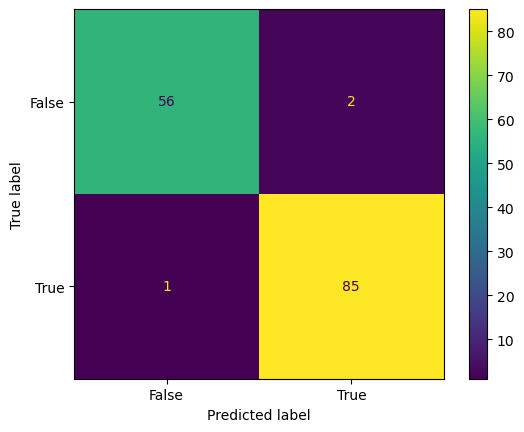

In [36]:
cm_display.plot()

In [37]:
Recall = cm[1][1] / (cm[1][1] + cm[1][0])
Recall * 100

98.83720930232558

In [45]:
recall_list = [98.83, 97.67, 98.83, 98.83, 98.83, 98.83, 97.67, 98.83, 97.67, 98.83]
recall_array = np.array(recall_list)
avg_recall = np.mean(recall_array)
std_recall = np.std(recall_array)

print("Average Recall: ", avg_recall)
print("Variance: ", std_recall)

Average Recall:  98.482
Variance:  0.5315787806148758


In [39]:
Precision = cm[1][1] / (cm[1][1] + cm[0][1])
Precision* 100

97.70114942528735

In [43]:
precision_list = [98.83, 97.67, 97.70, 97.70, 97.70, 98.83, 96.55, 96.59, 97.67, 97.10]

precision_array = np.array(precision_list)
avg_precision = np.mean(precision_array)
std_precision = np.std(precision_array)

print("Average Precision: ", avg_precision)
print("Variance: ", std_precision)

Average Precision:  97.63399999999999
Variance:  0.7366573151744301


In [40]:
F_score = 2*(Precision*Recall)/(Precision + Recall)
F_score * 100

98.26589595375722

In [44]:
f_score_list = [98.83, 97.67, 98.26, 98.26, 98.26, 98.83, 97.10, 97.10, 97.67, 98.26]
f_score_array = np.array(f_score_list)
avg_f_score = np.mean(f_score_array)
std_f_score = np.std(f_score_array)

print("Average F-score: ", avg_f_score)
print("Variance: ", std_f_score)

Average F-score:  98.02399999999999
Variance:  0.5899355897045052
